# Climate factors affecting wild fire analysis 
### using Machine learning Scikit-learn

**-- Data Prerequisite--** 
* Downloadd the wildfire sqllite data(data.sqlite) from kaggle https://www.kaggle.com/datasets/behroozsohrabi/us-wildfire-records-6th-edition    
* Download the climate data from NOAA(https://www.ncdc.noaa.gov/cdo-web/datasets) 
* Using the reusable data_merger.ipynb(juypter sourcefile) merge both climate and wild fire data for the years 2013 to 2020 and created the "final_data.csv" used for wildfire prediction based on climate factor

In [17]:
# Import required modules and packages 
import sqlite3 # to read and extract wildfire data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# required packages for random forest analysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Import required dependencies for neural network analysis
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [32]:
# Ref https://docs.python.org/3/library/sqlite3.html'

# place the downloaded data.sqlite from kaggle under resources folder
# read the file path
input_filename = "Resources/data.sqlite"

#create a sql connection to the sqlite
conn = sqlite3.connect(input_filename)

#crete a query string to extract the data from sqlite
query = '''
    SELECT * FROM Fires;
'''

# run the query and stored the data int to a dataframe
us_wild_fire_df = pd.read_sql_query(query, conn)

# display the dataframe info
us_wild_fire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2303566 entries, 0 to 2303565
Data columns (total 39 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   OBJECTID                       int64  
 1   Shape                          object 
 2   FOD_ID                         int64  
 3   FPA_ID                         object 
 4   SOURCE_SYSTEM_TYPE             object 
 5   SOURCE_SYSTEM                  object 
 6   NWCG_REPORTING_AGENCY          object 
 7   NWCG_REPORTING_UNIT_ID         object 
 8   NWCG_REPORTING_UNIT_NAME       object 
 9   SOURCE_REPORTING_UNIT          object 
 10  SOURCE_REPORTING_UNIT_NAME     object 
 11  LOCAL_FIRE_REPORT_ID           object 
 12  LOCAL_INCIDENT_ID              object 
 13  FIRE_CODE                      object 
 14  FIRE_NAME                      object 
 15  ICS_209_PLUS_INCIDENT_JOIN_ID  object 
 16  ICS_209_PLUS_COMPLEX_JOIN_ID   object 
 17  MTBS_ID                        object 
 18  MT

In [38]:
year = '2014'
# read the file path
input_filename = "Resources/data.sqlite"

#create a sql connection to the sqlite
conn = sqlite3.connect(input_filename)

#crete a query string to extract the data from sqlite
query = '''
    SELECT * FROM Fires WHERE FIRE_YEAR=2013;
'''
print(query)
print("Executing query with year:", year)
# run the query and stored the data int to a dataframe
wildfires = pd.read_sql_query(query, conn, params={"year": year})

# display the dataframe info
wildfires.head()


    SELECT * FROM Fires WHERE FIRE_YEAR=2013;

Executing query with year: 2014


,OBJECTID,Shape,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,...,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,1634256,b'\x00\x01\xad\x10\x00\x00t}\x90\xac\xf6\xc3^\...,201760001,FS-1512595,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,...,1450,0.1,A,40.391944,-123.061944,USFS,CA,105,06105,Trinity County
1,1634257,b'\x00\x01\xad\x10\x00\x00 q\xcc\x08\xc80^\xc0...,201760002,FS-1511339,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,...,1138,0.1,A,38.858056,-120.762222,USFS,CA,017,06017,El Dorado County
2,1634258,b'\x00\x01\xad\x10\x00\x00\xf4Z\xd0{\xc3\x98\\...,201760003,FS-1514180,FED,FS-FIRESTAT,FS,USMTBRF,Bitterroot National Forest,0103,...,1556,0.1,A,45.786667,-114.386944,USFS,MT,081,30081,Ravalli County
3,1634259,b'\x00\x01\xad\x10\x00\x00 \x8a6\xb8\xee\x0e^\...,201760004,FS-1513526,FED,FS-FIRESTAT,FS,USCATNF,Tahoe National Forest,0517,...,1457,0.1,A,39.152222,-120.233333,USFS,CA,061,06061,Placer County
4,1634260,"b""\x00\x01\xad\x10\x00\x00\xd4!7\xc3\xcd'[\xc0...",201760005,FS-1518204,FED,FS-FIRESTAT,FS,USCOSJF,San Juan National Forest,0213,...,1100,0.1,A,37.691667,-108.621944,USFS,CO,083,08083,Montezuma County


## Wildfire view 

In [4]:
#### Cleaning up the dataframe
# Using the data frame info, 
# Retain only required columns=['FOD_ID','SOURCE_SYSTEM_TYPE','FIRE_NAME''FIRE_YEAR','DISCOVERY_DATE',
#                                 'NWCG_CAUSE_CLASSIFICATION','NWCG_GENERAL_CAUSE', 'CONT_DATE',
#                                 'FIRE_SIZE','FIRE_SIZE_CLASS','LATITUDE','LONGITUDE','STATE'])
# Drop the unwanted columns based on column index.

us_wild_fire_df = us_wild_fire_df.drop(us_wild_fire_df.columns[[0,1,3,5,6,7,8,9,10,11,12,13,
                                                15,16,17,18,19,22,23,26,28,29,34,36,37,38 ]],axis = 1)

# Drop null value rows 
us_wild_fire_df.dropna(inplace=True)

# Drop the rows that contains missing values 
remove_rows_list = ['Missing data','not specified', 'undetermined', 'Missing data/not specified/undetermined']
us_wild_fire_df = us_wild_fire_df[us_wild_fire_df.NWCG_CAUSE_CLASSIFICATION.isin(remove_rows_list)==False]

# add month column using DISCOVERY_DATE
us_wild_fire_df['FIRE_START_MONTH'] = pd.to_datetime(us_wild_fire_df['DISCOVERY_DATE'], format='%m/%d/%Y').dt.strftime('%b')

# display the dataframe                 
us_wild_fire_df.head()                             

,FOD_ID,SOURCE_SYSTEM_TYPE,FIRE_NAME,FIRE_YEAR,DISCOVERY_DATE,NWCG_CAUSE_CLASSIFICATION,NWCG_GENERAL_CAUSE,CONT_DATE,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,FIRE_START_MONTH
0,1,FED,FOUNTAIN,2005,2/2/2005,Human,Power generation/transmission/distribution,2/2/2005,0.10,A,40.036944,-121.005833,CA,Feb
1,2,FED,PIGEON,2004,5/12/2004,Natural,Natural,5/12/2004,0.25,A,38.933056,-120.404444,CA,May
2,3,FED,SLACK,2004,5/31/2004,Human,Debris and open burning,5/31/2004,0.10,A,38.984167,-120.735556,CA,May
3,4,FED,DEER,2004,6/28/2004,Natural,Natural,7/3/2004,0.10,A,38.559167,-119.913333,CA,Jun
4,5,FED,STEVENOT,2004,6/28/2004,Natural,Natural,7/3/2004,0.10,A,38.559167,-119.933056,CA,Jun


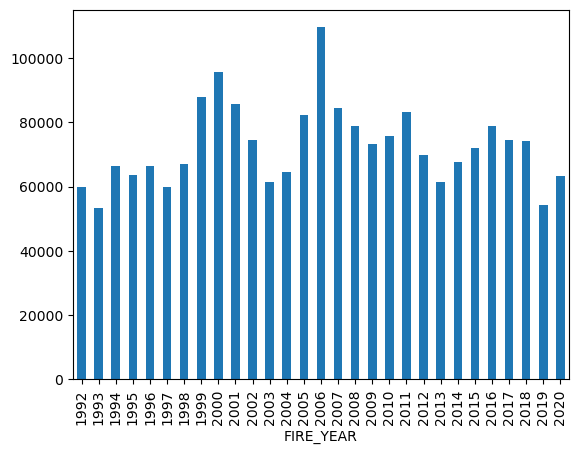

In [24]:
#Ref: https://www.geeksforgeeks.org/plot-the-size-of-each-group-in-a-groupby-object-in-pandas/
# Significance of the fire : visuvalize the fire occurance by each year and month
us_wild_fire_df.groupby(['FIRE_YEAR']).size().plot(kind='bar')
plt.show()

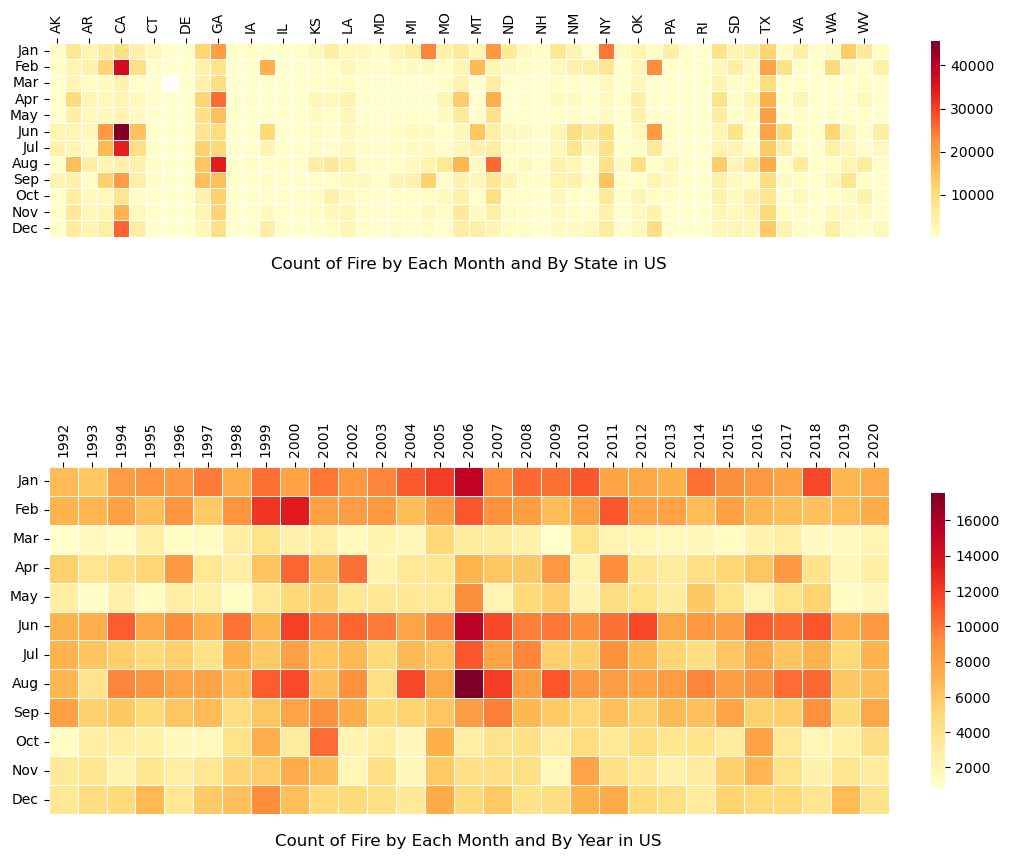

In [54]:
# Need the count of fire by each month and by each state to display a heat map to see which month and which state has highest fire
# https://www.geeksforgeeks.org/pandas-groupby-unstack/

# Create 2 row axis plot
fig, (ax1,ax2) = plt.subplots(2,figsize=(10,10),constrained_layout=True )

# Create xais and y axis input data for the plot
wild_fire_by_month_state = us_wild_fire_df.groupby(['FIRE_START_MONTH', 'STATE']).size().unstack() # ax1 x-axis input data
wild_fire_by_month_year = us_wild_fire_df.groupby(['FIRE_START_MONTH', 'FIRE_YEAR']).size().unstack() # ax2 x-axis input data
yaxis_labelvalue = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'] # y-axis input


# plot the result

ax1.set_title('Count of Fire by Each Month and By State in US', y=0, pad=-25, verticalalignment="bottom")
state_plot = sns.heatmap(wild_fire_by_month_state, ax=ax1, cmap='YlOrRd',linewidths=.5, linecolor='white',square=True,cbar_kws={"shrink": 0.4})
ax1.xaxis.tick_top()
state_plot.tick_params(labelrotation=90)
state_plot.set_yticklabels(yaxis_labelvalue, rotation=0)
state_plot.set(yticklabels=yaxis_labelvalue)
state_plot.set(xlabel='') 
state_plot.set(ylabel='')
# save the plot
plt.savefig('Images/Countof_FireEvents_ByMonth_and_state.png', format='png', dpi=200)

ax2.set_title('Count of Fire by Each Month and By Year in US', y=0, pad=-25, verticalalignment="bottom")
year_plot = sns.heatmap(wild_fire_by_month_year, ax=ax2, cmap='YlOrRd',linewidths=.5, linecolor='white',square=True,cbar_kws={"shrink": 0.6})
ax2.xaxis.tick_top()
year_plot.tick_params(labelrotation=90)
year_plot.set_yticklabels(yaxis_labelvalue, rotation=0)
year_plot.set(xlabel='')
year_plot.set(ylabel='')
# save the plot
plt.savefig('Images/Countof_FireEvents_ByMonth_and_Year.png', format='png', dpi=200)

# display the plot
plt.show()

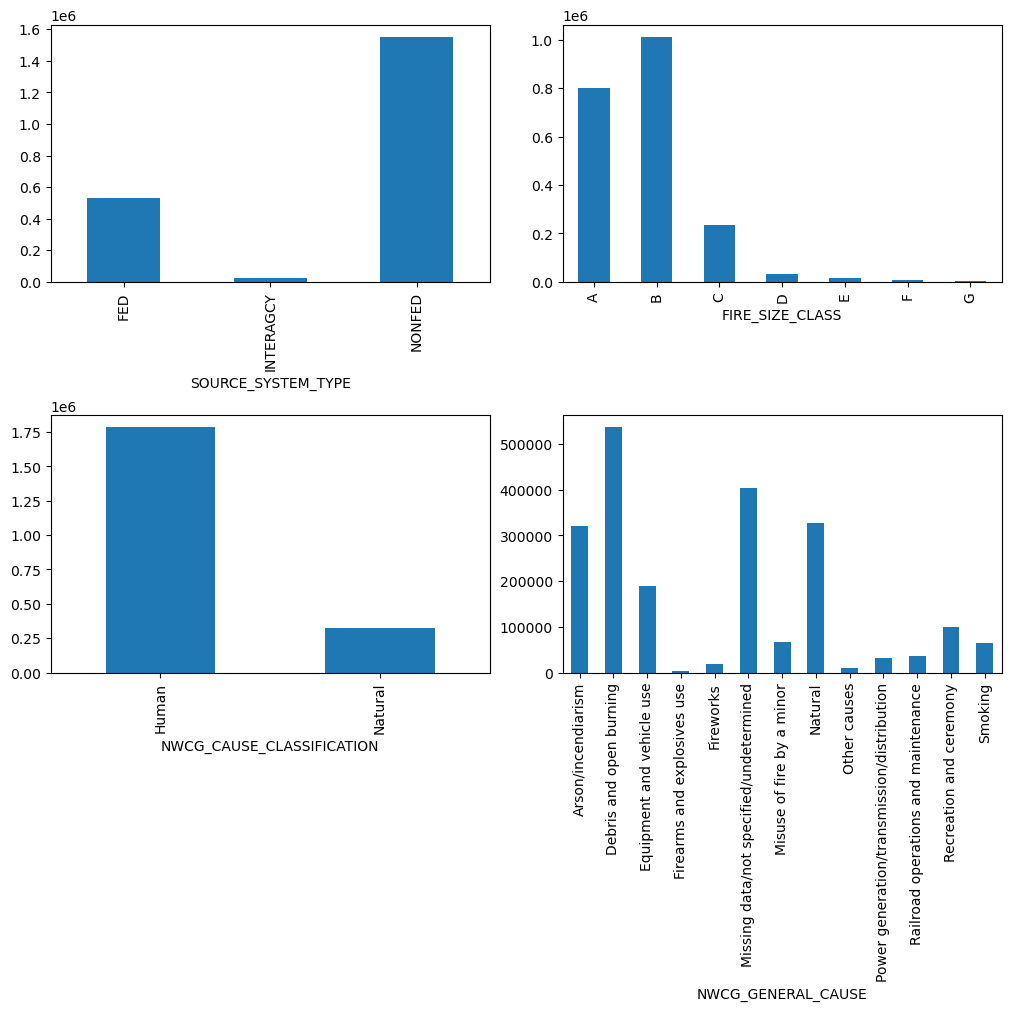

In [5]:
# view of wildfire by classification and cause
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),constrained_layout=True)    
us_wild_fire_df.groupby(['SOURCE_SYSTEM_TYPE']).size().plot(kind='bar',ax=axes[0,0] )
us_wild_fire_df.groupby(['FIRE_SIZE_CLASS']).size().plot(kind='bar',ax=axes[0,1])
us_wild_fire_df.groupby(['NWCG_CAUSE_CLASSIFICATION']).size().plot(kind='bar',ax=axes[1,0])
us_wild_fire_df.groupby(['NWCG_GENERAL_CAUSE']).size().plot(kind='bar',ax=axes[1,1] )
plt.savefig('Images/view_of_wildfire_by_classification_cause.png', format='png', dpi=200)
plt.show()

## ML Data Model Implementation and Analysis

### Preparing the data

In [31]:
# Ensure below prerequisite is met
    # Using the reusable data_merger.ipynb(juypter sourcefile) 
    # merge both climate data from NOAA and wild fire sqlite data from kaggle
    # for the years 2013 to 2020 and create the "climate_wildfire.sqlite". 
    # place the "climate_wildfire.sqlite" file under Resources folder
# ---------------------------------------------------------------#
# read the file path
input_filename = "Resources/climate_wildfire.sqlite"

#create a sql connection to the sqlite
conn = sqlite3.connect(input_filename)

#crete a query string to extract the data from sqlite
query = '''
    SELECT * FROM climate_fire;
'''

# run the query and stored the data int to a dataframe
df_climate_fires = pd.read_sql_query(query, conn)

# display the dataframe info
df_climate_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 955138 entries, 0 to 955137
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FIRE_NAME             955138 non-null  object 
 1   STATE                 955138 non-null  object 
 2   FIPS_CODE             900319 non-null  object 
 3   FIRE_LATITUDE         955138 non-null  object 
 4   FIRE_LONGITUDE        955138 non-null  object 
 5   FIRE_DATE             955138 non-null  object 
 6   CONTAIN_DATE          819050 non-null  object 
 7   CLOSEST_STATION       955138 non-null  object 
 8   STATION_STATE         955138 non-null  object 
 9   STATION_LAT           955138 non-null  float64
 10  STATION_LON           955138 non-null  float64
 11  READINGS_DATE         955138 non-null  object 
 12  CAUSE_CLASSIFICATION  955138 non-null  object 
 13  FIRE_SIZE             955138 non-null  object 
 14  FIRE_SIZE_CLASS       955138 non-null  object 
 15  

In [10]:
# cleaning up the dataframe
# remove unwanted columns
df_climate_fires.drop(["DAYS_TO_CONTAIN","CAUSE_CLASSIFICATION","FIRE_SIZE_CLASS","FIRE_SIZE",
                "DAYS_TO_CONTAIN","FIRE_NAME","CLOSEST_STATION","STATE","CONTAIN_DATE",
                "FIRE_DATE","READINGS_DATE","FIPS_CODE","FIRE_LATITUDE","FIRE_LONGITUDE","STATION_STATE"], axis=1, inplace=True) 

# display the dataframe
df_climate_fires

,STATION_LAT,STATION_LON,ELEVATION,TAVG,TMAX,TMIN,PRCP,SNOW,SNWD,AWND,FIRE_?
0,61.16916,-150.02771,38.0,118,161,67,0,0,0,47,1
1,64.80309,-147.87606,131.1,153,211,117,5,0,0,34,1
2,64.80309,-147.87606,131.1,197,250,139,18,0,0,19,1
3,64.80309,-147.87606,131.1,114,117,106,8,0,0,30,1
4,64.80309,-147.87606,131.1,190,244,117,0,0,0,20,1
...,...,...,...,...,...,...,...,...,...,...,...
955133,42.23113,-83.33121,191.9,-76,-49,-93,20,38,30,56,0
955134,45.07160,-83.56451,208.3,-122,-99,-177,3,5,230,32,0
955135,42.88210,-85.52297,240.3,-89,-77,-99,28,74,100,47,0
955136,42.39834,-90.70913,316.9,-179,-143,-238,30,61,180,28,0


### Predicting the fire occurance using Random forest
##### Which climate feature contributed to fire occurances

In [13]:
# Define features set
X = df_climate_fires.copy()
X.drop(["FIRE_?"], axis=1, inplace=True) 

# Define target vector
y = df_climate_fires["FIRE_?"].ravel()
y[:5]

# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Fitting the Random Forest Model

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

## Making Predictions Using the Random Forest Model
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

## Model Evaluation
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

   STATION_LAT  STATION_LON  ELEVATION  TAVG  TMAX  TMIN  PRCP  SNOW  SNWD  \
0     61.16916   -150.02771       38.0   118   161    67     0     0     0   
1     64.80309   -147.87606      131.1   153   211   117     5     0     0   
2     64.80309   -147.87606      131.1   197   250   139    18     0     0   
3     64.80309   -147.87606      131.1   114   117   106     8     0     0   
4     64.80309   -147.87606      131.1   190   244   117     0     0     0   

   AWND  
0    47  
1    34  
2    19  
3    30  
4    20  
[1 1 1 1 1]
Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,79411,13909
Actual 1,10972,134493


Accuracy Score : 0.8958016625834956
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86     93320
           1       0.91      0.92      0.92    145465

    accuracy                           0.90    238785
   macro avg       0.89      0.89      0.89    238785
weighted avg       0.90      0.90      0.90    238785



##### Feature Importance

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

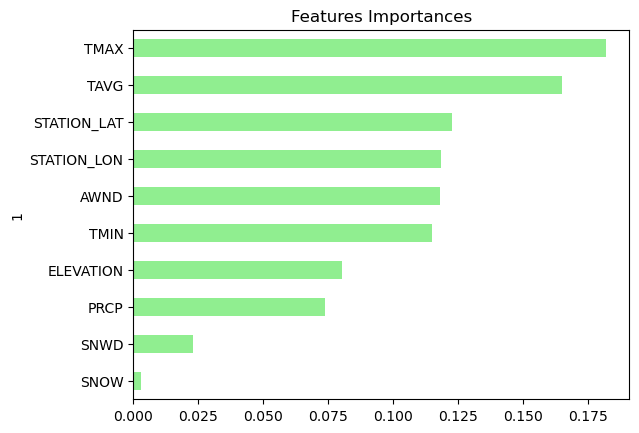

In [14]:
# Random Forests in sklearn will automatically calculate feature importance
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

Based on Random state analysis it is observed that the top three key features which contributed to fire occurances are maximium temperature, location and wind.

This model has a accuracy of 90% with precision at around 91% and recall at 92% which could potentially mean there is a possiblity of false positive and false negative could be less than 10%. This could be due to data as each climate factor has various considerations and all factors are is not considered for this analysis.

On overall the model would predicts realiable fire occurance and it performed pretty good.

### Predicting the fire occurance using Neural Network